In [1]:
import configparser
import os
import argparse
import ast
import sys
import time
import random
from collections import defaultdict
import logging

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from torchvision.datasets import DatasetFolder
from torchvision import models, datasets
from torchvision import transforms as Transforms

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import auc, precision_recall_curve, confusion_matrix, classification_report

from transformers import pipeline, AutoModel

import timm
from timm.data import resolve_data_config, resolve_model_data_config
from timm.data.transforms_factory import create_transform

from tqdm.notebook import tqdm

/home/jerlshin/anaconda3/envs/gnn/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/jerlshin/anaconda3/envs/gnn/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/jerlshin/anaconda3/envs/gnn/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/i

In [2]:
SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


In [3]:
class Config:
    MODEL_NAME = "hf_hub:timm/mambaout_base.in1k"
    NUM_CLASSES = 14
    IMAGE_SIZE = 224
    
    BATCH_SIZE = 64
    NUM_EPOCHS = 50
    LR = 1e-4
    WEIGHT_DECAY = 1e-5
    
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
    
    SEED = 42
    SAVE_DIR = "./checkpoints"
    LOG_DIR = "./logs"
    
    NUM_FOLDS = 5

## Data Setup

In [ ]:
config_parser = configparser.ConfigParser()
config_parser.read("/home/model/visible_images_config.ini")

In [5]:
if "visible_images" in config_parser and "labels" in config_parser:
    images_path = config_parser["visible_images"]["data"]
    labels = config_parser["labels"]["label_path"]
else:
    raise ValueError("Dataset configuration not found in config_parser")

In [6]:
label_df = pd.read_csv(labels)

In [7]:
label_df.columns

Index(['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min',
       'x_max', 'y_max'],
      dtype='object')

In [8]:
label_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [9]:
label_df = label_df.drop(columns=["rad_id", "x_min", "x_max", "y_min", "y_max", "class_id"])

label_df.head()

,image_id,class_name
0,50a418190bc3fb1ef1633bf9678929b3,No finding
1,21a10246a5ec7af151081d0cd6d65dc9,No finding
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement
4,063319de25ce7edb9b1c6b8881290140,No finding


In [11]:
label_df[label_df["class_name"] == "No finding"]

,image_id,class_name
0,50a418190bc3fb1ef1633bf9678929b3,No finding
1,21a10246a5ec7af151081d0cd6d65dc9,No finding
4,063319de25ce7edb9b1c6b8881290140,No finding
12,5550a493b1c4554da469a072fdfab974,No finding
13,869f39afbdd8783b531530942eda8bad,No finding
...,...,...
67905,955f258cc29153f996ee6716218c1196,No finding
67909,936fd5cff1c058d39817a08f58b72cae,No finding
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding
67911,aa17d5312a0fb4a2939436abca7f9579,No finding


In [12]:
label_df = label_df[label_df["class_name"] != "No finding"].reset_index(drop=True)

In [13]:
label_df["class_name"].unique(), len(label_df["class_name"].unique())

(array(['Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'ILD',
        'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Atelectasis',
        'Other lesion', 'Infiltration', 'Pleural effusion',
        'Calcification', 'Consolidation', 'Pneumothorax'], dtype=object),
 14)

In [14]:
label_df.head()

,image_id,class_name
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass


In [15]:
unique_classes = sorted(set(label_df["class_name"]))

In [16]:
unique_classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [17]:
map_idx_label = {class_name: idx for idx, class_name in enumerate(unique_classes)}

In [18]:
map_idx_label

{'Aortic enlargement': 0,
 'Atelectasis': 1,
 'Calcification': 2,
 'Cardiomegaly': 3,
 'Consolidation': 4,
 'ILD': 5,
 'Infiltration': 6,
 'Lung Opacity': 7,
 'Nodule/Mass': 8,
 'Other lesion': 9,
 'Pleural effusion': 10,
 'Pleural thickening': 11,
 'Pneumothorax': 12,
 'Pulmonary fibrosis': 13}

In [19]:
label_df["class_id"] = label_df["class_name"].map(map_idx_label)

In [20]:
label_df["class_name"].unique(), label_df["class_id"].unique(), len(label_df["class_id"].unique())

(array(['Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'ILD',
        'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Atelectasis',
        'Other lesion', 'Infiltration', 'Pleural effusion',
        'Calcification', 'Consolidation', 'Pneumothorax'], dtype=object),
 array([ 3,  0, 11,  5,  8, 13,  7,  1,  9,  6, 10,  2,  4, 12]),
 14)

### Model

In [148]:
# model to train

model_name = "hf_hub:timm/mambaout_base.in1k"

model = timm.create_model(model_name=model_name, pretrained=True)

Loading pretrained weights from Hugging Face hub (timm/mambaout_base.in1k)
[timm/mambaout_base.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [149]:
model.head

MlpHead(
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (pre_logits): Sequential(
    (fc): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate='none')
    (norm): LayerNorm((3072,), eps=1e-06, elementwise_affine=True)
  )
  (fc): Linear(in_features=3072, out_features=1000, bias=True)
  (head_dropout): Dropout(p=0.0, inplace=False)
)

In [142]:
model.head.fc

Linear(in_features=3072, out_features=1000, bias=True)

In [150]:
model.head.in_features

768

In [151]:
model.head.fc.in_features

3072

In [152]:
in_features = model.head.fc.in_features

model.head.fc = nn.Linear(in_features, Config.NUM_CLASSES)

In [153]:
dummy_image = torch.randn((1, 3, 224, 224))

In [154]:
out = model(dummy_image)

In [155]:
out.shape

torch.Size([1, 14])

In [25]:
# batch_size, channels, height, width = 4, 3, 224, 224

# img = torch.randn(batch_size, channels, height, width)
# img = torch.randint(low=0, high=255, size=(batch_size, channels, height, width), dtype=torch.uint8)

# output = model(transforms(img))                       # (batch_size, num_features)

# """Granular model"""
# output = model.forward_features(transforms(img))        # (1, 7, 7, 768)
# output = model.forward_head(output, pre_logits=True)    # (1, num_features)

In [26]:
# Iterate over named parameters
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}, Trainable: {param.requires_grad}")

Parameter name: stem.conv1.weight, Shape: torch.Size([64, 3, 3, 3]), Trainable: True
Parameter name: stem.conv1.bias, Shape: torch.Size([64]), Trainable: True
Parameter name: stem.norm1.weight, Shape: torch.Size([64]), Trainable: True
Parameter name: stem.norm1.bias, Shape: torch.Size([64]), Trainable: True
Parameter name: stem.conv2.weight, Shape: torch.Size([128, 64, 3, 3]), Trainable: True
Parameter name: stem.conv2.bias, Shape: torch.Size([128]), Trainable: True
Parameter name: stem.norm2.weight, Shape: torch.Size([128]), Trainable: True
Parameter name: stem.norm2.bias, Shape: torch.Size([128]), Trainable: True
Parameter name: stages.0.blocks.0.norm.weight, Shape: torch.Size([128]), Trainable: True
Parameter name: stages.0.blocks.0.norm.bias, Shape: torch.Size([128]), Trainable: True
Parameter name: stages.0.blocks.0.fc1.weight, Shape: torch.Size([682, 128]), Trainable: True
Parameter name: stages.0.blocks.0.fc1.bias, Shape: torch.Size([682]), Trainable: True
Parameter name: stages

In [27]:
# Count trainable parameters
total_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 79380810


In [28]:
print(model.head)

Linear(in_features=768, out_features=14, bias=True)


In [ ]:
class classifier1(nn.Module):
    def __init__(self, in_features, num_classes):
        super(classifier1, self).__init__()
        self.fc1 = nn.Linear(in_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [30]:
in_features = model.head.in_features

in_features

768

In [31]:
model

MambaOut(
  (stem): Stem(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
    (act): GELU(approximate='none')
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): MambaOutStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): GatedConvBlock(
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (fc1): Linear(in_features=128, out_features=682, bias=True)
          (act): GELU(approximate='none')
          (conv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (fc2): Linear(in_features=341, out_features=128, bias=True)
          (ls): Identity()
          (drop_path): Identity()
        )
        (1): GatedConvBlock(
          (norm): LayerNorm((128,), eps=1e-06, elementw

In [ ]:
model_classifier = classifier1(in_features=in_features, num_classes=Config.NUM_CLASSES)

In [126]:
dummy_image = torch.randn((1, 3, 224, 224))

In [127]:
out = model(dummy_image)

In [128]:
out.shape

torch.Size([1, 7, 7, 14])

In [34]:
features = model.forward_features(dummy_image)

In [35]:
features.shape

torch.Size([4, 7, 7, 768])

In [36]:
model.head

Linear(in_features=768, out_features=14, bias=True)

In [37]:
class_names = label_df["class_name"].unique().tolist()

In [38]:
class_names

['Cardiomegaly',
 'Aortic enlargement',
 'Pleural thickening',
 'ILD',
 'Nodule/Mass',
 'Pulmonary fibrosis',
 'Lung Opacity',
 'Atelectasis',
 'Other lesion',
 'Infiltration',
 'Pleural effusion',
 'Calcification',
 'Consolidation',
 'Pneumothorax']

### Data Loading

In [39]:
data_config = timm.data.resolve_data_config(model.default_cfg)

In [40]:
model.default_cfg

{'hf_hub_id': 'timm/mambaout_base.in1k',
 'source': 'hf-hub',
 'architecture': 'mambaout_base',
 'tag': 'in1k',
 'custom_load': False,
 'input_size': [3, 224, 224],
 'test_input_size': [3, 288, 288],
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225],
 'num_classes': 1000,
 'pool_size': [7, 7],
 'first_conv': 'stem.conv1',
 'classifier': 'head.fc'}

In [41]:
default_transforms = timm.data.transforms_factory.create_transform(**data_config)

In [42]:
default_transforms

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [ ]:
class datasett(Dataset):
    def __init__(self, image_dir, map_idx_label, label_df, transform=None):
        self.image_dir = image_dir
        self.map_idx_label = map_idx_label
        self.label_df = label_df
        self.transform = transform
        
        if "image_id" not in label_df.columns or "class_id" not in label_df.columns:
            raise ValueError("label_df must contain 'image_id' and 'class_id' columns")

    def __len__(self):
        return len(self.label_df)

    def __getitem__(self, idx):
        row = self.label_df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["image_id"] + ".png")
        image = Image.open(img_path).convert("RGB")
        
        label = row["class_id"]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


* Transforms

In [44]:
default_transform_list = list(default_transforms.transforms)

default_transform_list

[Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn),
 CenterCrop(size=(224, 224)),
 MaybeToTensor(),
 Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))]

In [45]:
train_augmentations = [
    # Transforms.RandomHorizontalFlip(),
    # Transforms.RandomRotation(15), # rotate +- 15 deg
    # Transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
]

train_transform = Transforms.Compose(train_augmentations + default_transform_list)

val_transform = Transforms.Compose(default_transform_list)

In [46]:
train_transform

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [47]:
val_transform

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

## Training

In [48]:
skf = StratifiedKFold(n_splits=Config.NUM_FOLDS, shuffle=True, random_state=Config.SEED)

In [ ]:
dataset = datasett(
    image_dir=images_path, 
    map_idx_label=map_idx_label, 
    label_df=label_df, 
    transform=train_transform
)

In [50]:
sorted(set(dataset.label_df["class_id"]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

### Focal Loss

In [51]:
class_counts = label_df["class_id"].value_counts().sort_index().values

total_samples = len(label_df)

<BarContainer object of 14 artists>

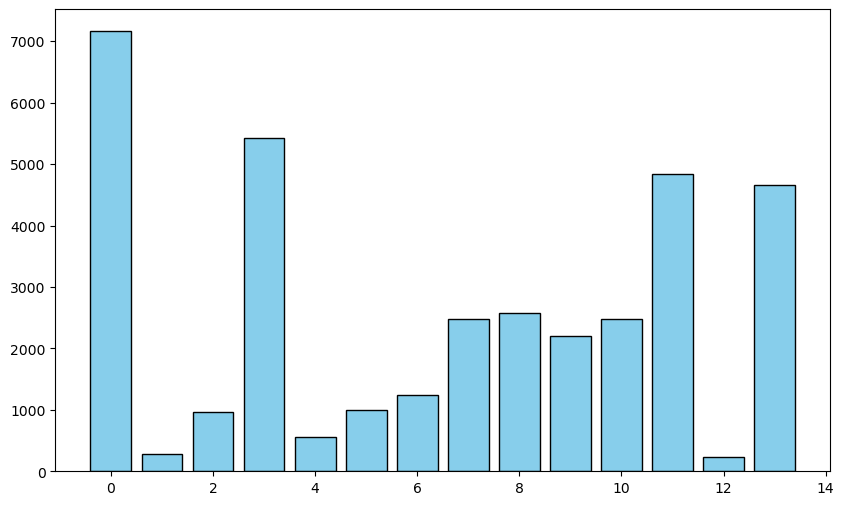

In [52]:
class_ids = label_df["class_id"].value_counts().sort_index().index

plt.figure(figsize=(10, 6))
plt.bar(class_ids, class_counts, color='skyblue', edgecolor='black')

In [53]:
map_idx_label

{'Aortic enlargement': 0,
 'Atelectasis': 1,
 'Calcification': 2,
 'Cardiomegaly': 3,
 'Consolidation': 4,
 'ILD': 5,
 'Infiltration': 6,
 'Lung Opacity': 7,
 'Nodule/Mass': 8,
 'Other lesion': 9,
 'Pleural effusion': 10,
 'Pleural thickening': 11,
 'Pneumothorax': 12,
 'Pulmonary fibrosis': 13}

In [54]:
# inv freq
class_weights = total_samples / (len(class_counts) * class_counts)
# norm
class_weights = class_weights / class_weights.sum()

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(Config.DEVICE)

In [55]:
print("Class Weights for Focal Loss:", class_weights_tensor)

Class Weights for Focal Loss: tensor([0.0093, 0.2382, 0.0692, 0.0122, 0.1195, 0.0665, 0.0533, 0.0268, 0.0258,
        0.0302, 0.0268, 0.0137, 0.2941, 0.0143])


In [ ]:
class focalloss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(focalloss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        
        num_classes = logits.shape[-1]
        
        # Ensure targets are in the valid range
        targets = targets.long().clamp(0, num_classes - 1)
        
        probs = F.softmax(logits, dim=1)
        
        targets_one_hot = F.one_hot(targets, num_classes=num_classes).float()

        ce_loss = -targets_one_hot * torch.log(probs + 1e-8)
        
        focal_loss = self.alpha * (1 - probs) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [114]:
logits = torch.randn([4, 7, 7, 14])  # batch size is 2 and in each batch there are 4 elements... and total classes are [-1] 5 in this case

targets = torch.tensor([12, 11,  9,  7])
alpha = torch.tensor([0.25, 0.5, 0.25])

num_classes = logits.shape[-1]

print(num_classes)

14


In [115]:
targets = targets.long().clamp(0, num_classes - 1)
probs = F.softmax(logits, dim=1)

In [117]:
targets_one_hot = F.one_hot(targets, num_classes=num_classes).float()


In [119]:
targets

tensor([12, 11,  9,  7])

In [118]:
targets_one_hot

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [120]:
probs.shape

torch.Size([4, 7, 7, 14])

In [121]:
targets_one_hot.shape

torch.Size([4, 14])

In [ ]:
criterion = focalloss(alpha=alpha, gamma=2.0, reduction='mean')

In [156]:
# criterion(logits, labels)

In [ ]:
class model1:
    def __init__(self, model, dataset, config):
        self.model = model
        self.dataset = dataset
        self.config = config
        self.device = config.DEVICE
        self.criterion = focalloss(alpha=class_weights_tensor, gamma=2.0)
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)

        self.writer = SummaryWriter(log_dir=config.LOG_DIR)

        os.makedirs(config.SAVE_DIR, exist_ok=True)
        os.makedirs(config.LOG_DIR, exist_ok=True)

        log_file = os.path.join(config.LOG_DIR, "training.log")
        logging.basicConfig(filename=log_file, level=logging.INFO, 
                            format="%(asctime)s - %(levelname)s - %(message)s", filemode="w")
        self.logger = logging.getLogger()
        self.logger.addHandler(logging.StreamHandler())
        
    def log(self, message):
        """Prints and logs a message."""
        self.logger.info(message)
        print(message)

    def train_one_epoch(self, train_loader, epoch, fold):
        self.model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for images, labels in tqdm(train_loader, desc=f"Training Fold {fold}, Epoch {epoch}", leave=False):
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_loss = running_loss / len(train_loader)
        accuracy = accuracy_score(all_labels, all_preds) * 100
        precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
        recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
        f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

        self.writer.add_scalar(f"Fold_{fold}/Train/Loss", avg_loss, epoch)
        self.writer.add_scalar(f"Fold_{fold}/Train/Accuracy", accuracy, epoch)
        self.writer.add_scalar(f"Fold_{fold}/Train/Precision", precision, epoch)
        self.writer.add_scalar(f"Fold_{fold}/Train/Recall", recall, epoch)
        self.writer.add_scalar(f"Fold_{fold}/Train/F1-Score", f1, epoch)

        self.log(f"Fold {fold}, Epoch {epoch} - Train Loss: {avg_loss:.4f}, Acc: {accuracy:.2f}%, Prec: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

        return avg_loss, accuracy, precision, recall, f1

    def validate(self, val_loader, epoch, fold):
        self.model.eval()
        running_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Validation Fold {fold}, Epoch {epoch}", leave=False):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = running_loss / len(val_loader)
        accuracy = accuracy_score(all_labels, all_preds) * 100
        precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
        recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
        f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

        self.writer.add_scalar(f"Fold_{fold}/Val/Loss", avg_loss, epoch)
        self.writer.add_scalar(f"Fold_{fold}/Val/Accuracy", accuracy, epoch)
        self.writer.add_scalar(f"Fold_{fold}/Val/Precision", precision, epoch)
        self.writer.add_scalar(f"Fold_{fold}/Val/Recall", recall, epoch)
        self.writer.add_scalar(f"Fold_{fold}/Val/F1-Score", f1, epoch)

        self.log(f"Fold {fold}, Epoch {epoch} - Val Loss: {avg_loss:.4f}, Acc: {accuracy:.2f}%, Prec: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

        return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

    def plot_confusion_matrix(self, labels, preds):
        cm = confusion_matrix(labels, preds)
        class_names = sorted(set(self.dataset.label_df["class_name"]))
        df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

        plt.figure(figsize=(10, 7))
        sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")

        cm_path = os.path.join(self.config.LOG_DIR, "confusion_matrix.png")
        plt.savefig(cm_path)
        plt.close()

        self.log(f"Confusion matrix saved at {cm_path}")

    def run_training(self):
        skf = StratifiedKFold(n_splits=self.config.NUM_FOLDS, shuffle=True, random_state=self.config.SEED)
        labels = self.dataset.label_df["class_id"].values
        all_indices = list(skf.split(np.zeros(len(labels)), labels))
        test_indices = all_indices[-1]

        best_model = None
        best_val_acc = 0.0

        for fold in range(self.config.NUM_FOLDS - 1):
            train_indices, val_indices = all_indices[fold]
            train_loader = DataLoader(Subset(self.dataset, train_indices), batch_size=self.config.BATCH_SIZE, shuffle=True)
            val_loader = DataLoader(Subset(self.dataset, val_indices), batch_size=self.config.BATCH_SIZE, shuffle=False)

            for epoch in range(self.config.NUM_EPOCHS):
                self.train_one_epoch(train_loader, epoch, fold)
                _, val_acc, *_ = self.validate(val_loader, epoch, fold)

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model = self.model.state_dict()

        self.model.load_state_dict(best_model)
        _, test_indices = test_indices
        test_loader = DataLoader(Subset(self.dataset, test_indices), batch_size=self.config.BATCH_SIZE, shuffle=False)
        test_loss, test_acc, *_ = self.validate(test_loader, 0, "Test")

        self.log(f"\nFinal Test Set Results -> Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")
        self.plot_confusion_matrix(test_loader.dataset.targets, test_loader.dataset.targets)

        return best_model


In [162]:
model

MambaOut(
  (stem): Stem(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
    (act): GELU(approximate='none')
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): MambaOutStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): GatedConvBlock(
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (fc1): Linear(in_features=128, out_features=682, bias=True)
          (act): GELU(approximate='none')
          (conv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (fc2): Linear(in_features=341, out_features=128, bias=True)
          (ls): Identity()
          (drop_path): Identity()
        )
        (1): GatedConvBlock(
          (norm): LayerNorm((128,), eps=1e-06, elementw

In [ ]:
trainer = model1(model=model, dataset=dataset, config=Config)

In [164]:
np.unique(trainer.dataset.label_df["class_id"])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [165]:
best_model = trainer.run_training()

torch.save(best_model, "best_model.pth")

Training Fold 0, Epoch 0:   0%|          | 0/7219 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [77]:
tensor = torch.randn([4, 7, 7, 14])

In [79]:
tensor.shape[-1]

14